<a href="https://colab.research.google.com/github/DrAlexSanz/micrograd/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal of this notebook

* Understand how does automatic differentiation work

Lecture here https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1

In [1]:
import math
from graphviz import Digraph
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Make a function to demonstrate operations
def f(x):
    return 3*x**2 - 4*x +5

f(3.0)

20.0

Text(0.5, 1.0, 'Beautiful parabola')

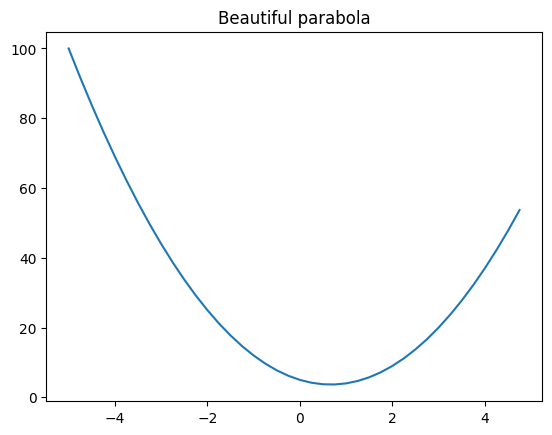

In [3]:
xs = np.arange(-5, 5, 0.25) # Now get a vector of inputs and pass it to the function for plotting

ys = f(xs)

plt.plot(xs, ys)
plt.title("Beautiful parabola")

Now, I could calculate the derivative using the rules because it's an easy one. Alternatively I can use the definition of derivative.

$$ f'(x) = lim_{x \rightarrow 0} \frac{f(x + h) - f(x)}{h} $$


In [4]:
# I define
h = 0.00001 # Too small and the numerator will underflow.
x = 3.0
print(f"f(x + h) = {f(x + h)}")
print(f"f(x) = {f(x)}")
der = (f(x + h) - f(x))/h
print(f"f'(3) = {der}") # This should be 14 with a small error.


f(x + h) = 20.0001400003
f(x) = 20.0
f'(3) = 14.00003000000538


In [5]:
# And now for the negative side, the derivative should be negative
h = 0.00001 # Too small and the numerator will underflow.
x = -3.0
print(f"f(x + h) = {f(x + h)}")
print(f"f(x) = {f(x)}")
der = (f(x + h) - f(x))/h
print(f"f'(3) = {der}") # This should be 14 with a small error.


f(x + h) = 43.9997800003
f(x) = 44.0
f'(3) = -21.999970000052823


In [6]:
# And now I know that the minimum is at 2/3 more or less
h = 0.00001 # Too small and the numerator will underflow.
x = 2/3
print(f"f(x + h) = {f(x + h)}")
print(f"f(x) = {f(x)}")
der = (f(x + h) - f(x))/h
print(f"f'(3) = {der}") # This should be 14 with a small error.


f(x + h) = 3.666666666966667
f(x) = 3.666666666666667
f'(3) = 3.0000002482211127e-05


Now let's do a more complicated function

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c

print(d)

4.0


Let's evaluate the derivative of the new function with respect to a, b and c

In [8]:
h = 0.0001 # Too small and the numerator will underflow.

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c # This is f(x)

# d1/da
a = a + h # add h to a
d2 = a * b + c # This is f(x + h)

d1_da = (d2 - d1)/h

print("d1 = ", d1) # This should be 4
print("d2 = ", d2) # This should be close to 4 (smaller in this case)
print("d1_da = ", d1_da) # This should be -3 for this point (using the rules)

# And this works the same way for b and c

# d1/db
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c

b = b + h # add h to b
d2 = a * b + c # This is f(x + h)

d1_db = (d2 - d1)/h

print("d1 = ", d1) # This should be 4
print("d2 = ", d2) # This should be close to 4 (smaller in this case)
print("d1_db = ", d1_db) # This should be 2 for this point (using the rules)

# d1/dc
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

c = c + h # add h to c
d2 = a * b + c # This is f(x + h)

d1_dc = (d2 - d1)/h

print("d1 = ", d1) # This should be 4
print("d2 = ", d2) # This should be close to 4 (smaller in this case)
print("d1_dc = ", d1_dc) # This should be 1 for this point (using the rules)

d1 =  4.0
d2 =  3.999699999999999
d1_da =  -3.000000000010772
d1 =  4.0
d2 =  4.0002
d1_db =  2.0000000000042206
d1 =  4.0
d2 =  4.0001
d1_dc =  0.9999999999976694


So this is an intuitive idea of how all this autodiff thing works.

Now we build the first draft of the Value object (class) of Micrograd

In [9]:
class Value():
    def __init__(self, data, _children = (), _op = ""): # _children starts as an empty tuple. Operation is a string (add, mul...)
        self.data = data
        self._prev = set(_children) # Make it a set for efficiency. If I write a = Value(2.0), prev is the empty set.
        self._op = _op

    def __repr__(self): # Instead of printing the memory address, print something readable
        return f"Value(data = {self.data})"
    
    def __add__(self, other): # Need to define what addition means
        out = Value(self.data + other.data, (self, other), "+") # Returns another Value object. And we define the symbol for the operation.
        return out
    
    def __mul__(self, other): # Need to define what multiplication means
        out = Value(self.data * other.data, (self, other), "*") # Returns another Value object. And we define the symbol for the operation.
        return out
    

    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
# And what Python does internally is:
#(a.__mul__(b)).__add__(c) # If you run this it should say Value(data = 4.0)

In [10]:
# See what d._prev gives.

print(d._prev) #These are the previous nodes that I used to create d. -6 corresponds to a*b and 10 is c
print(d._op) #This is the operation that created d

{Value(data = -6.0), Value(data = 10.0)}
+


I want a way to display the operations tree

In [15]:
def trace(root):
    # Build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = "svg", graph_attr = {"rankdir": "LR"}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For each node, create a rectangular node for it
        dot.node(name = uid, label = "{ data %.4f }" %(n.data, ), shape = "record")
        if n._op:
          # If this node is the result of an operation, create a node for it
          dot.node(name = uid + n._op, label = n._op)
        # And connect the node to the rectangle
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect output of n1 to input of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

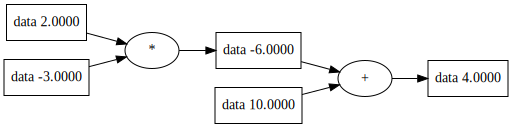

In [16]:
draw_dot(d)